In [1]:
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder

census = pd.read_csv('acs2017_census_tract_data.csv')
df = census.copy()
#df.info()
df = df.dropna()
df = df.drop('County', axis=1)
#df.info()
df[['State']] = df[['State']].apply(LabelEncoder().fit_transform)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           72718 non-null  int64  
 1   State             72718 non-null  int32  
 2   TotalPop          72718 non-null  int64  
 3   Men               72718 non-null  int64  
 4   Women             72718 non-null  int64  
 5   Hispanic          72718 non-null  float64
 6   White             72718 non-null  float64
 7   Black             72718 non-null  float64
 8   Native            72718 non-null  float64
 9   Asian             72718 non-null  float64
 10  Pacific           72718 non-null  float64
 11  VotingAgeCitizen  72718 non-null  int64  
 12  Income            72718 non-null  float64
 13  IncomeErr         72718 non-null  float64
 14  IncomePerCap      72718 non-null  float64
 15  IncomePerCapErr   72718 non-null  float64
 16  Poverty           72718 non-null  float6

,TractId,State,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,0,1845,899,946,2.4,86.3,5.2,0.0,1.2,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,0,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,0,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,0,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,0,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


We decided to drop the county variable due to the fact that the counties represent political subdivision which are subject to jerrymandering. The tractId is the preferred area identifier employed by the census bureau. 

In [2]:
#[.5 points] Balance the dataset so that about the same number of instances are within each class. Choose a method for
#balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization 
#thresholds for the "ChildPoverty" variable that equally divide the data into four classes. Should balancing of the 
#dataset be done for both the training and testing set? Explain.

from sklearn.model_selection import train_test_split

df_target = df['ChildPoverty']
df_data = df.drop(['ChildPoverty'], axis=1)

X = df_data.copy()
y = df_target.copy()

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, test_size=0.2)
y_train.describe()

count    58174.000000
mean        21.159437
std         18.516111
min          0.000000
25%          6.300000
50%         16.400000
75%         31.600000
max        100.000000
Name: ChildPoverty, dtype: float64

In [3]:
y_train = y_train.div(100)
y_train = pd.qcut(y_train,q=4,labels=[1,2,3,4],precision=0)
y_train.value_counts()

1    14694
4    14539
2    14502
3    14439
Name: ChildPoverty, dtype: int64

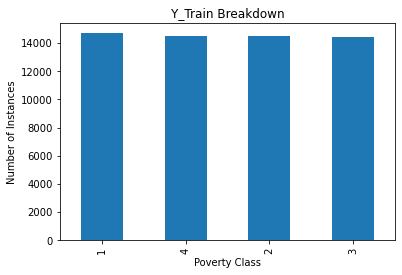

In [4]:
import matplotlib.pyplot as plt
count = y_train.value_counts()
count.plot.bar()
plt.title('Y_Train Breakdown')
plt.ylabel('Number of Instances')
plt.xlabel('Poverty Class')
plt.show()

Here we will only balance the testing set because in order to create a reliable prediction model we need to have the testing set to represent unseen and untouched data which will help us verify the model for deployment. 

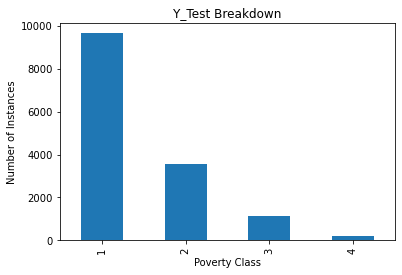

In [5]:
y_test = pd.cut(y_test,bins=4,labels=[1,2,3,4],precision=0)
y_test.value_counts()
count = y_test.value_counts()
count.plot.bar()
plt.title('Y_Test Breakdown')
plt.ylabel('Number of Instances')
plt.xlabel('Poverty Class')
plt.show()

We decided to balance our training set using the quantile cut function from pandas which will create four classes of equal instances utilizing the quartiles thresholds. However this method will not help policy makers differentiate between communities in the final quartile of child poverty and the truly impoverished communities because the final quartile threshold of the training data begins at 31% poverty but the most impoverished communities are above 75% child poverty which is represented as class 4 in the testing set breakdown. 

In [6]:
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import StandardScaler 
import numpy as np 

y_train = y_train.to_numpy(dtype='int64')
X_train = X_train.to_numpy()
y_test = y_test.to_numpy(dtype='int64')
X_test = X_test.to_numpy()

In [7]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(58174,)
(58174, 35)
(14544,)
(14544, 35)


## Two Layer Perception utilizing Mini-Batching, Cross Entropy Gradient Calculation, Glorot Initialization

In [8]:
from scipy.special import expit
import sys 

class TwoLayerPerceptron(object):
    def __init__(self, n_hidden=1,
                 C=0.0, epochs=500, eta=0.1, random_state=None, shuffle=True, 
                 minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatches = minibatches

    @staticmethod
    def _encode_labels(y):
        onehot = pd.get_dummies(y).values.T
            
        return onehot
        
    def _initialize_weights(self):
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0

        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        V2 = (A3-Y_enc)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T

        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

    def fit(self, X, y, print_progress=False, XY_test=None):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()
        
        self.grad_W1_ = np.zeros(self.epochs)
        self.grad_W2_ = np.zeros(self.epochs)

        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost)

                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)
                
                self.grad_W1_[i] = np.average(np.sqrt(np.sum(np.square(grad1))))
                self.grad_W2_[i] = np.average(np.sqrt(np.sum(np.square(grad2))))


                self.W1 -= self.eta * grad1
                self.W2 -= self.eta * grad2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self
    
    def predict(self, X):
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

In [9]:
 params = {'n_hidden':20,
         'C':0.01, 'epochs':100, 'eta':0.001,'minibatches':len(X_train)/35,
         'shuffle':True,'random_state':1}

In [10]:
%%time
nn_2mcg = TwoLayerPerceptron(**params)

nn_2mcg.fit(X_train, y_train, print_progress=1)
yhat = nn_2mcg.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 100/100

Accuracy: 0.07900165016501651
CPU times: total: 2min 3s
Wall time: 46.5 s


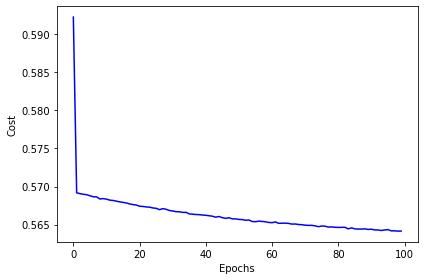

In [12]:
import matplotlib.pyplot as plt
# take the mean of each minibatch epoch
cost_avgs = [np.mean(x) for x in nn_2mcg.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='blue')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

Now we will see how our two layer perceptron performs when we normalize the continuous training data

In [13]:
 from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV

sdf = census.copy()
sdf = sdf.dropna()
sdf = sdf.drop('County', axis=1)
sdf[['State']] = sdf[['State']].apply(LabelEncoder().fit_transform)
sdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           72718 non-null  int64  
 1   State             72718 non-null  int32  
 2   TotalPop          72718 non-null  int64  
 3   Men               72718 non-null  int64  
 4   Women             72718 non-null  int64  
 5   Hispanic          72718 non-null  float64
 6   White             72718 non-null  float64
 7   Black             72718 non-null  float64
 8   Native            72718 non-null  float64
 9   Asian             72718 non-null  float64
 10  Pacific           72718 non-null  float64
 11  VotingAgeCitizen  72718 non-null  int64  
 12  Income            72718 non-null  float64
 13  IncomeErr         72718 non-null  float64
 14  IncomePerCap      72718 non-null  float64
 15  IncomePerCapErr   72718 non-null  float64
 16  Poverty           72718 non-null  float6

In [14]:
sdf_target = sdf['ChildPoverty']
sdf_data = sdf.drop(['ChildPoverty'], axis=1)
X = sdf_data.copy()
y = sdf_target.copy()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, test_size=0.2)

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [16]:
y_train = y_train.div(100)
y_train = pd.qcut(y_train,q=4,labels=[1,2,3,4],precision=0)
y_test = pd.cut(y_test,bins=4,labels=[1,2,3,4],precision=0)

In [17]:
y_train = y_train.to_numpy(dtype='int64')
y_test = y_test.to_numpy(dtype='int64')

In [18]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(58174,)
(58174, 35)
(14544,)
(14544, 35)


In [20]:
params = {'n_hidden':20,
         'C':0.01, 'epochs':100, 'eta':0.001,'minibatches':len(X_train)/35,
         'shuffle':True,'random_state':1}

In [19]:
%%time
nn_2mcg = TwoLayerPerceptron(**params)

nn_2mcg.fit(X_train, y_train, print_progress=1)
yhat = nn_2mcg.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 100/100

Accuracy: 0.4275302530253025
CPU times: total: 1min 41s
Wall time: 37.2 s


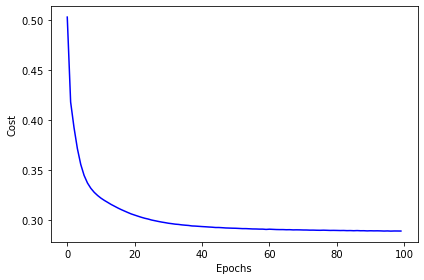

In [21]:
cost_avgs = [np.mean(x) for x in nn_2mcg.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='blue')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

Next, we will one hot encode the categorical data and normalize the continuous data after the training and test split

In [22]:
cdf = census.copy()
onehot = pd.get_dummies(cdf['State'], prefix='State')
cdf = cdf.dropna()
cdf = cdf.drop('County', axis=1)
cdf = cdf.drop('State', axis=1)
cdf = cdf.join(onehot)
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 87 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   TractId                     72718 non-null  int64  
 1   TotalPop                    72718 non-null  int64  
 2   Men                         72718 non-null  int64  
 3   Women                       72718 non-null  int64  
 4   Hispanic                    72718 non-null  float64
 5   White                       72718 non-null  float64
 6   Black                       72718 non-null  float64
 7   Native                      72718 non-null  float64
 8   Asian                       72718 non-null  float64
 9   Pacific                     72718 non-null  float64
 10  VotingAgeCitizen            72718 non-null  int64  
 11  Income                      72718 non-null  float64
 12  IncomeErr                   72718 non-null  float64
 13  IncomePerCap                727

In [23]:
cdf_target = cdf['ChildPoverty']
cdf_data = cdf.drop(['ChildPoverty'], axis=1)

X = cdf_data.copy()
y = cdf_target.copy()

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, test_size=0.2)
y_train.describe()

count    58174.000000
mean        21.132941
std         18.514755
min          0.000000
25%          6.200000
50%         16.400000
75%         31.600000
max        100.000000
Name: ChildPoverty, dtype: float64

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [25]:
y_train = y_train.div(100)
y_train = pd.qcut(y_train,q=4,labels=[1,2,3,4],precision=0)
y_test = pd.cut(y_test,bins=4,labels=[1,2,3,4],precision=0)

In [26]:
y_train = y_train.to_numpy(dtype='int64')
y_test = y_test.to_numpy(dtype='int64')

In [27]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(58174,)
(58174, 86)
(14544,)
(14544, 86)


In [29]:
%%time
nn_2mcg = TwoLayerPerceptron(**params)

nn_2mcg.fit(X_train, y_train, print_progress=1)
yhat = nn_2mcg.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 100/100

Accuracy: 0.4245049504950495
CPU times: total: 2min 9s
Wall time: 1min 2s


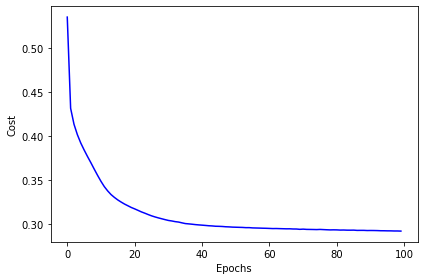

In [30]:
cost_avgs = [np.mean(x) for x in nn_2mcg.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='blue')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

As you can see from the three models above, the loss function versus the number of epoch smoothens out and converges earlier once you normalize and onehot encode the categorical and continuous data. Along with smoother plots, the accuracies increased throughout the three models

## Multi Layer Perceptrons with Average Magnitude Gradient For Each Layer Plots

In [32]:
class ThreeLayerPerceptron(object):
    def __init__(self, n_hidden=1,
                 C=0.0, epochs=500, eta=0.1, random_state=None, shuffle=True, 
                 minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatches = minibatches

    @staticmethod
    def _encode_labels(y):
        onehot = pd.get_dummies(y).values.T
            
        return onehot
        
    def _initialize_weights(self):
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W2[:,:1] = 0

        init_bound = 4*np.sqrt(6. / (self.n_output_ + self.n_hidden + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W3[:,:1] = 0
        
        return W1, W2, W3
    
    @staticmethod
    def _sigmoid(z):
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2))
    
    def _cost(self,A4,Y_enc,W1,W2,W3):
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A4)+(1-Y_enc)*np.log(1-A4))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3):
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4
    
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        V3 = (A4-Y_enc)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2[:-1,:])
        
        grad3 = V3 @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T

        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C

        return grad1, grad2, grad3

    def fit(self, X, y, print_progress=False, XY_test=None):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3 = self._initialize_weights()
        
        self.grad_W1_ = np.zeros(self.epochs)
        self.grad_W2_ = np.zeros(self.epochs)
        self.grad_W3_ = np.zeros(self.epochs)

        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3)
                
                cost = self._cost(A4,Y_enc[:, idx],self.W1,self.W2,self.W3)
                mini_cost.append(cost)

                grad1, grad2, grad3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3)
                
                self.grad_W1_[i] = np.average(np.sqrt(np.sum(np.square(grad1))))
                self.grad_W2_[i] = np.average(np.sqrt(np.sum(np.square(grad2))))
                self.grad_W3_[i] = np.average(np.sqrt(np.sum(np.square(grad3))))


                self.W1 -= self.eta * grad1
                self.W2 -= self.eta * grad2
                self.W3 -= self.eta * grad3

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self
    
    def predict(self, X):
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred

In [33]:
params = {'n_hidden':86,
         'C':0.01, 'epochs':100, 'eta':0.001,'minibatches':len(X_train)/35,
         'shuffle':True,'random_state':1}

In [34]:
%%time
nn_3mcg = ThreeLayerPerceptron(**params)

nn_3mcg.fit(X_train, y_train, print_progress=1)
yhat = nn_3mcg.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 100/100

Accuracy: 0.4086908690869087
CPU times: total: 9min 25s
Wall time: 2min 23s


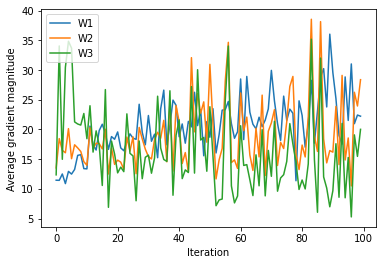

In [36]:
ax = plt.subplot(1,1,1)
plt.plot(abs(nn_3mcg.grad_W1_[:]), label='W1')
plt.plot(abs(nn_3mcg.grad_W2_[:]), label='W2')
plt.plot(abs(nn_3mcg.grad_W3_[:]), label='W3')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

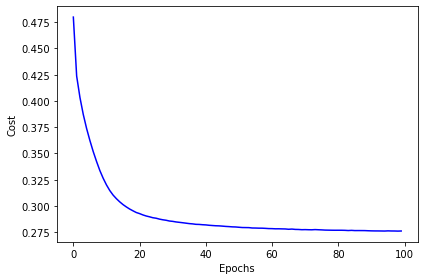

In [38]:
cost_avgs = [np.mean(x) for x in nn_3mcg.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='blue')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [39]:
class FourLayerPerceptron(object):
    def __init__(self, n_hidden=1,
                 C=0.0, epochs=500, eta=0.1, random_state=None, shuffle=True, 
                 minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatches = minibatches

    @staticmethod
    def _encode_labels(y):
        onehot = pd.get_dummies(y).values.T
            
        return onehot
        
    def _initialize_weights(self):
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W2[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W3[:,:1] = 0

        init_bound = 4*np.sqrt(6. / (self.n_output_ + self.n_hidden + 1))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W4[:,:1] = 0
        
        return W1, W2, W3, W4
    
    @staticmethod
    def _sigmoid(z):
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4):
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2))
    
    def _cost(self,A5,Y_enc,W1,W2,W3,W4):
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A5)+(1-Y_enc)*np.log(1-A5))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3, W4):
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5
    
    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        V4 = (A5-Y_enc)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3[:-1,:])
        V1 = A2*(1-A2)*(W2.T @ V2[:-1,:])
        
        grad4 = V4 @ A4.T
        grad3 = V3[1:,:] @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T

        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4

    def fit(self, X, y, print_progress=False, XY_test=None):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4 = self._initialize_weights()
        
        self.grad_W1_ = np.zeros(self.epochs)
        self.grad_W2_ = np.zeros(self.epochs)
        self.grad_W3_ = np.zeros(self.epochs)
        self.grad_W4_ = np.zeros(self.epochs)

        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4)
                
                cost = self._cost(A5,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4)
                mini_cost.append(cost)

                grad1, grad2, grad3, grad4 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4)
                
                self.grad_W1_[i] = np.average(np.sqrt(np.sum(np.square(grad1))))
                self.grad_W2_[i] = np.average(np.sqrt(np.sum(np.square(grad2))))
                self.grad_W3_[i] = np.average(np.sqrt(np.sum(np.square(grad3))))
                self.grad_W4_[i] = np.average(np.sqrt(np.sum(np.square(grad4))))


                self.W1 -= self.eta * grad1
                self.W2 -= self.eta * grad2
                self.W3 -= self.eta * grad3
                self.W4 -= self.eta * grad4

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self
    
    def predict(self, X):
        _, _, _, _, _, _, _, _, A5 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4)
        y_pred = np.argmax(A5, axis=0)
        return y_pred

In [40]:
params = {'n_hidden':86,
         'C':0.01, 'epochs':100, 'eta':0.001,'minibatches':len(X_train)/35,
         'shuffle':True,'random_state':1}

In [41]:
%%time
nn_4mcg = FourLayerPerceptron(**params)

nn_4mcg.fit(X_train, y_train, print_progress=1)
yhat = nn_4mcg.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 100/100

Accuracy: 0.4336496149614962
CPU times: total: 13min 49s
Wall time: 3min 30s


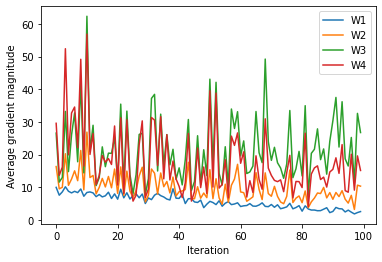

In [42]:
ax = plt.subplot(1,1,1)
plt.plot(abs(nn_4mcg.grad_W1_[:]), label='W1')
plt.plot(abs(nn_4mcg.grad_W2_[:]), label='W2')
plt.plot(abs(nn_4mcg.grad_W3_[:]), label='W3')
plt.plot(abs(nn_4mcg.grad_W4_[:]), label='W4')

plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

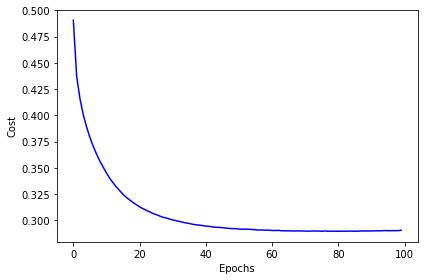

In [43]:
cost_avgs = [np.mean(x) for x in nn_4mcg.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='blue')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [44]:
class FiveLayerPerceptron(object):
    def __init__(self, n_hidden=1,
                 C=0.0, epochs=500, eta=0.1, random_state=None, shuffle=True, 
                 minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatches = minibatches

    @staticmethod
    def _encode_labels(y):
        onehot = pd.get_dummies(y).values.T
            
        return onehot
        
    def _initialize_weights(self):
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W2[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W3[:,:1] = 0
        
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W4[:,:1] = 0

        init_bound = 4*np.sqrt(6. / (self.n_output_ + self.n_hidden + 1))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W5[:,:1] = 0
        
        return W1, W2, W3, W4, W5
    
    @staticmethod
    def _sigmoid(z):
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2)  + np.mean(W5[:, 1:] ** 2))
    
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A6)+(1-Y_enc)*np.log(1-A6))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4,W5)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, W3, W4,W5):
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4)
        A5 = self._add_bias_unit(A5, how='row')
        Z5 = W5 @ A5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4,W5):
        V5 = (A6-Y_enc)
        V4 = A5*(1-A5)*(W5.T @ V5)
        V3 = A4*(1-A4)*(W4.T @ V4[:-1,:])
        V2 = A3*(1-A3)*(W3.T @ V3[:-1,:])
        V1 = A2*(1-A2)*(W2.T @ V2[:-1,:])
        
        grad5 = V5 @ A5.T
        grad4 = V4[1:,:] @ A4.T
        grad3 = V3[1:,:] @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T

        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4, grad5

    def fit(self, X, y, print_progress=False, XY_test=None):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()
        
        self.grad_W1_ = np.zeros(self.epochs)
        self.grad_W2_ = np.zeros(self.epochs)
        self.grad_W3_ = np.zeros(self.epochs)
        self.grad_W4_ = np.zeros(self.epochs)
        self.grad_W5_ = np.zeros(self.epochs)

        self.cost_ = []
        self.score_ = []
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.W3,
                                                       self.W4,
                                                       self.W5)
                
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost)

                grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, 
                                                                       Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4,W5=self.W5)
                
                self.grad_W1_[i] = np.average(np.sqrt(np.sum(np.square(grad1))))
                self.grad_W2_[i] = np.average(np.sqrt(np.sum(np.square(grad2))))
                self.grad_W3_[i] = np.average(np.sqrt(np.sum(np.square(grad3))))
                self.grad_W4_[i] = np.average(np.sqrt(np.sum(np.square(grad4))))
                self.grad_W5_[i] = np.average(np.sqrt(np.sum(np.square(grad5))))



                self.W1 -= self.eta * grad1
                self.W2 -= self.eta * grad2
                self.W3 -= self.eta * grad3
                self.W4 -= self.eta * grad4
                self.W5 -= self.eta * grad5

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self
    
    def predict(self, X):
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred

In [45]:
params = {'n_hidden':86,
         'C':0.01, 'epochs':100, 'eta':0.001,'minibatches':len(X_train)/35,
         'shuffle':True,'random_state':1}

In [46]:
%%time
nn_5mcg = FiveLayerPerceptron(**params)

nn_5mcg.fit(X_train, y_train, print_progress=1)
yhat = nn_5mcg.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 100/100

Accuracy: 0.4430693069306931
CPU times: total: 16min 35s
Wall time: 4min 11s


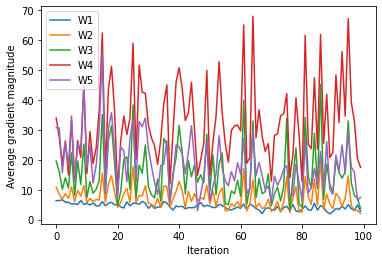

In [47]:
ax = plt.subplot(1,1,1)
plt.plot(abs(nn_5mcg.grad_W1_[:]), label='W1')
plt.plot(abs(nn_5mcg.grad_W2_[:]), label='W2')
plt.plot(abs(nn_5mcg.grad_W3_[:]), label='W3')
plt.plot(abs(nn_5mcg.grad_W4_[:]), label='W4')
plt.plot(abs(nn_5mcg.grad_W5_[:]), label='W5')

plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

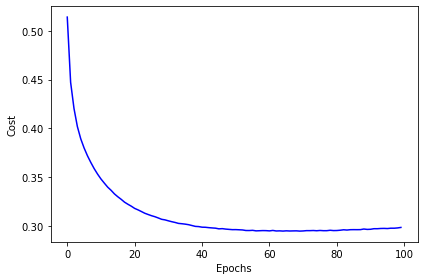

In [48]:
cost_avgs = [np.mean(x) for x in nn_5mcg.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='blue')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [ ]:
#[2 points] Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network
#(such as AdaGrad, RMSProps, or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five
#layer model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique as it 
#is part of the exceptional work.


In [ ]:
#Exceptional Work (1 points total)
#One idea (required for 7000 level students):  Implement adaptive momentum (AdaM) in the 
#five layer neural network and quantify the performance